In [1]:
SEEEEEDDDD = 8888

In [2]:
# Import semua library yang dibutuhkan
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.cm as cm

from datetime import datetime as dt
from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

### EDA

In [3]:
# Import dataset
data_raw = pd.read_csv("customer_segmentation.csv")
data_raw.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
# Check struktur data dan jenis variable tiap column
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Deksripsi Variabel:
1. ID: unique identifier untuk tiap orang  
2. Year_Birth: tahun kelahiran seseorang  
3. Education: tingkat pendidikan tertinggi seseorang  
4. Marital_Status: status pernikahan seseorang  
5. Income: pendapatan tahunan seseorang  
6. Kidhome: jumlah anak dalam rumah tangga  
7. Teenhome: jumlah remaja dalam rumah tangga  
8. Dt_Customer: tanggal ketika pelanggan pertama kali terdaftar  
9. Recency: jumlah hari sejak pembelian terakhir  
10. MntWines: jumlah uang yang digunakan untuk beli anggur  
11. MntFruits: jumlah uang yang digunakan untuk beli buah-buahan  
12. MntMeatProducts: jumlah uang yang digunakan untuk beli produk daging  
13. MntFishProducts: jumlah uang yang digunakan untuk beli produk ikan  
14. MntSweetProducts: jumlah uang yang digunakan untuk beli produk manis  
15. MntGoldProds: jumlah uang yang digunakan untuk beli produk emas  
16. NumDealsPurchases: jumlah pembelian yang dilakukan dengan diskon atau penawaran khusus  
17. NumWebPurchases: jumlah pembelian yang dilakukan melalui web perusahaan  
18. NumCatalogPurchases: jumlah pembelian yang dilakukan melalui katalog  
19. NumStorePurchases: jumlah pembelian yang dilakukan di toko fisik  
20. NumWebVisitsMonth: jumlah kunjungan ke web perusahaan dalam satu bulan  
21. AcceptedCmp3: indikator (1 atau 0) apakah seseorang menerima kampanye marketing ke-3  
22. AcceptedCmp4: indikator (1 atau 0) apakah seseorang menerima kampanye marketing ke-4  
23. AcceptedCmp5: indikator (1 atau 0) apakah seseorang menerima kampanye marketing ke-5  
24. AcceptedCmp1: indikator (1 atau 0) apakah seseorang menerima kampanye marketing ke-1  
25. AcceptedCmp2: indikator (1 atau 0) apakah seseorang menerima kampanye marketing ke-2  
26. Complain: indikator (1 atau 0) apakah seseorang pernah mengajukan complain  
27. Z_CostContact: biaya tetap yang terkait dengan menghubungi pelanggan  
28. Z_Revenue: pendapatan tetap yang terkait dengan respons sukses terhadap kampanye  
29. Response: indikator (1 atau 0) apakah seseorang merespons kampanye marketing  

Bisa kita lihat di dataset ini terdiri dari 2240 observasi dengan 29 variabel berbeda. Ada sebuah variabel yang memiliki tipe data yang salah yaitu 'Dt_Customer', yang mana merupakan sebuah tanggal yang seharusnya bertipe data date. Dari seluruh variabel, hanya 1 variabel yang mengandung NULL value, yaitu 'Income'

In [5]:
# Mengubah tipe data menjadi datetime
data_raw['Dt_Customer'] = pd.to_datetime(data_raw['Dt_Customer'], format='%d-%m-%Y', errors='coerce')
now = dt.now() # tanggal sekarang
# Mengitung berapa bulan sejak orang tersebut mendaftar
data_raw['Month_Cust'] = (now.year - data_raw['Dt_Customer'].dt.year) * 12 + (now.month - data_raw['Dt_Customer'].dt.month).astype(int) # Mengkali selisih tahun dgn 12 dan ditambah selisih bulan
data_raw.drop('Dt_Customer', axis=1, inplace=True) # Membuang column krn sudah tidak dibutuhkan

In [6]:
# Membuat column baru yaitu 'Age' yaitu umur seseorang yang didapatkan dari mengurangkan tahun sekarang dengan tahun lahir
data_raw['Age'] = (dt.now().year - data_raw['Year_Birth']).astype(int)
data_raw.drop('Year_Birth', axis=1, inplace=True) # Membuang column krn sudah tidak dibutuhkan

In [7]:
# Check duplikasi dari data
print(data_raw.duplicated().sum())

0


Ternyata tidak temukan adanya data yang duplikat

In [8]:
# Column id hanyalah sebuah unique identifier yang tidak berpengaruh pada analisa sehingga saya memutuskan untuk menghapus column ini
data_raw = data_raw.drop(columns=['ID'])
data_raw.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Month_Cust,Age
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,0,0,0,0,0,3,11,1,149,68
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,0,0,0,0,0,3,11,0,131,71
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,...,0,0,0,0,0,3,11,0,138,60
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,...,0,0,0,0,0,3,11,0,132,41
4,PhD,Married,58293.0,1,0,94,173,43,118,46,...,0,0,0,0,0,3,11,0,133,44


In [9]:
# Check presentase jumlah nilai NULL dari data
data_raw.isna().sum()/ len(data_raw) * 100

Education              0.000000
Marital_Status         0.000000
Income                 1.071429
Kidhome                0.000000
Teenhome               0.000000
Recency                0.000000
MntWines               0.000000
MntFruits              0.000000
MntMeatProducts        0.000000
MntFishProducts        0.000000
MntSweetProducts       0.000000
MntGoldProds           0.000000
NumDealsPurchases      0.000000
NumWebPurchases        0.000000
NumCatalogPurchases    0.000000
NumStorePurchases      0.000000
NumWebVisitsMonth      0.000000
AcceptedCmp3           0.000000
AcceptedCmp4           0.000000
AcceptedCmp5           0.000000
AcceptedCmp1           0.000000
AcceptedCmp2           0.000000
Complain               0.000000
Z_CostContact          0.000000
Z_Revenue              0.000000
Response               0.000000
Month_Cust             0.000000
Age                    0.000000
dtype: float64

Dari hasil diatas bisa dilihat nilai NULL di dataset ini hanya ada di column 'Income' dengan presentasi 1.07%. Dan karena 1% ini merupakan jumlah yang sangat sedikit jadi saya memutuskan untuk mendrop row yang memiliki NULL value 'Income'

In [10]:
# Menghapus semua row yang mengandung NULL value pada column 'Income'
data_raw = data_raw.dropna()
data_raw.isna().sum().sum()

0

Sekarang sudah tidak ditemukan lagi NULL value

In [11]:
# Descriptive Statistik untuk column numerical
data_raw.describe(exclude='object').T

,count,mean,std,min,25%,50%,75%,max
Income,2216.0,52247.251354,25173.076661,1730.0,35303.0,51381.5,68522.00,666666.0
Kidhome,2216.0,0.441787,0.536896,0.0,0.0,0.0,1.00,2.0
Teenhome,2216.0,0.505415,0.544181,0.0,0.0,0.0,1.00,2.0
Recency,2216.0,49.012635,28.948352,0.0,24.0,49.0,74.00,99.0
MntWines,2216.0,305.091606,337.327920,0.0,24.0,174.5,505.00,1493.0
MntFruits,2216.0,26.356047,39.793917,0.0,2.0,8.0,33.00,199.0
MntMeatProducts,2216.0,166.995939,224.283273,0.0,16.0,68.0,232.25,1725.0
MntFishProducts,2216.0,37.637635,54.752082,0.0,3.0,12.0,50.00,259.0
MntSweetProducts,2216.0,27.028881,41.072046,0.0,1.0,8.0,33.00,262.0
MntGoldProds,2216.0,43.965253,51.815414,0.0,9.0,24.5,56.00,321.0


Dari statistik diatas, disimpulkan Z_CostContact dan Z_Revenue hanya mengandung satu nilai konstan yang berarti tidak ada informasi apapun di fitur ini sehingga saya akan drop

In [12]:
# Hapus columm Z_CostContact dan Z_Revenue
data_raw = data_raw.drop(columns=["Z_CostContact", "Z_Revenue"])

In [13]:
# Descriptive Statistik untuk column numerical
data_raw.describe(include='object').T

,count,unique,top,freq
Education,2216,5,Graduation,1116
Marital_Status,2216,8,Married,857


- Untuk column Education, terdiri dari 5 unique value dengan modus Graduation, yang berarti sebagian besar Customer merupakan lulusan S1
- Untuk column Marital_Status, terdiri dari 8 unique value dengan modus Married, yang berarti sebagian besar Customer merupakan orang yang sudah menikah

In [14]:
# Membuat list untuk menampung column numerical dan kategorical
numerical_cols = list(data_raw.select_dtypes(include=['number']).columns)
categorical_cols = list(data_raw.select_dtypes(include=['object']).columns)
print('Numerical columns:', numerical_cols)
print('Categorical columns:', categorical_cols)

Numerical columns: ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response', 'Month_Cust', 'Age']
Categorical columns: ['Education', 'Marital_Status']


In [15]:
# Hasil pembagian column diatas ada kesalahan karena ada variabel binary yang seharusnya masuk ke column categorical
binary_cols = [ "AcceptedCmp3", "AcceptedCmp4", "AcceptedCmp5", "AcceptedCmp1", "AcceptedCmp2", "Complain", "Response" ]
# Hapus column binary dari numerical
numerical_cols = [col for col in numerical_cols if col not in binary_cols]
# Menambahkan column binary ke column categrical
categorical_cols.extend(binary_cols)
print('Numerical columns:', numerical_cols)
print('Categorical columns:', categorical_cols)

Numerical columns: ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Month_Cust', 'Age']
Categorical columns: ['Education', 'Marital_Status', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Response']


In [16]:
# Check konsistensi data categorical
for i in categorical_cols:
    print(data_raw[i].value_counts(),'\n')

Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64 

Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

AcceptedCmp3
0    2053
1     163
Name: count, dtype: int64 

AcceptedCmp4
0    2052
1     164
Name: count, dtype: int64 

AcceptedCmp5
0    2054
1     162
Name: count, dtype: int64 

AcceptedCmp1
0    2074
1     142
Name: count, dtype: int64 

AcceptedCmp2
0    2186
1      30
Name: count, dtype: int64 

Complain
0    2195
1      21
Name: count, dtype: int64 

Response
0    1883
1     333
Name: count, dtype: int64 



Bisa dilihat jika column 'Education' bersifat ordinal karena ada tingkatan yg jelas berdasarkan level pendidikan (Basic,Graduation,2n Cycle,Master,PhD)

Sedangkan column 'Marital_Status' bersifat nominal karena tidak ada urutannya. Di column ini ada beberapa kategori yg invalid, yaitu Alone, Absurd, YOLO. Karena jumlah yang tidak valid sangat sedikit, jadi saya memutuskan untuk menghapus rownya

Untuk column-column binary lainnya tidak ditemukan keanehan


In [17]:
# List kategori invalid
invalid_cats = ["Alone", "YOLO", "Absurd"]
# Hapus row yang mengandung kategori tidak valid
data_raw = data_raw[~data_raw["Marital_Status"].isin(invalid_cats)].reset_index(drop=True)
data_raw["Marital_Status"].value_counts()

Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Name: count, dtype: int64

Graph Income


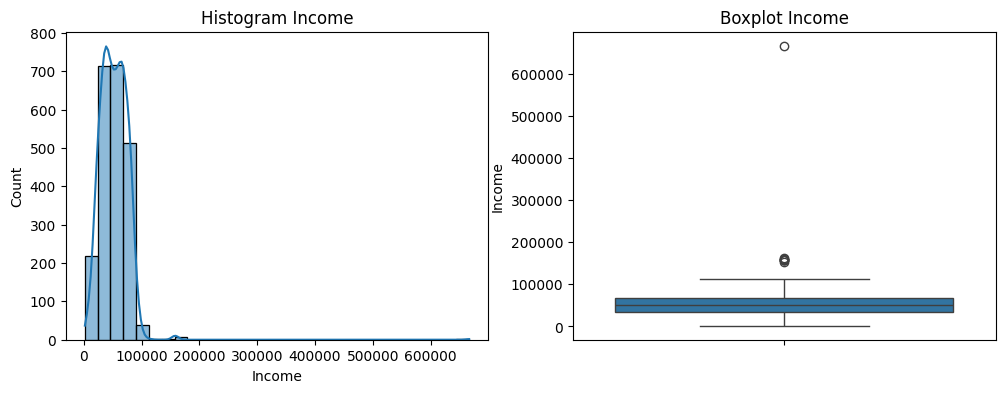

Skewness: 6.76
Kurtosis: 159.50


Graph Kidhome


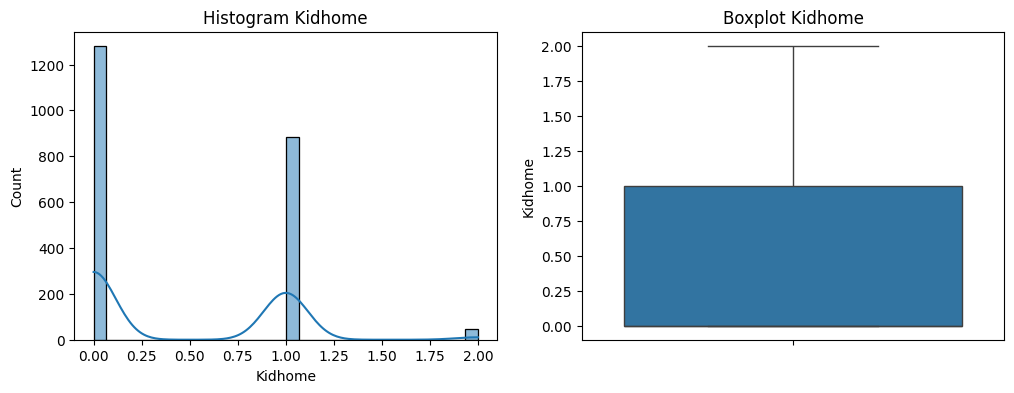

Skewness: 0.64
Kurtosis: -0.79


Graph Teenhome


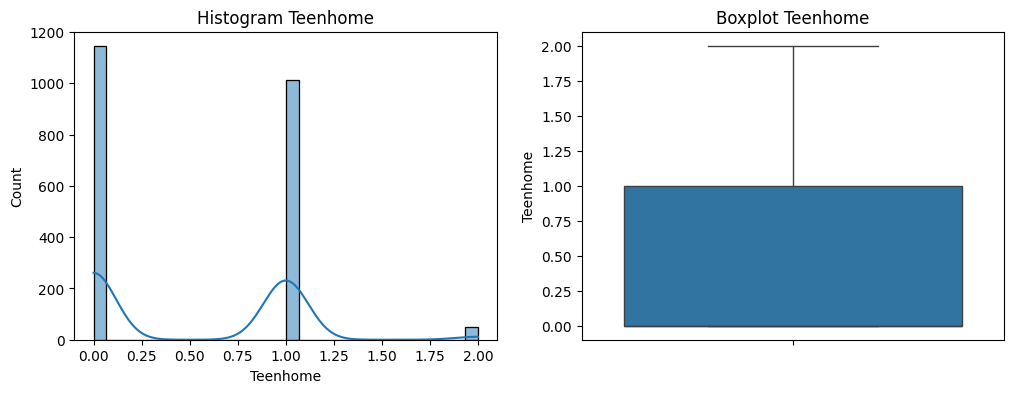

Skewness: 0.41
Kurtosis: -0.99


Graph Recency


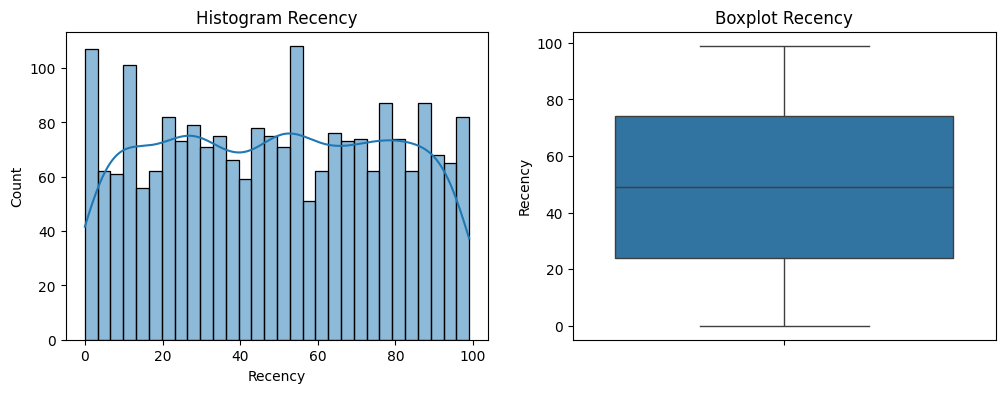

Skewness: -0.00
Kurtosis: -1.20


Graph MntWines


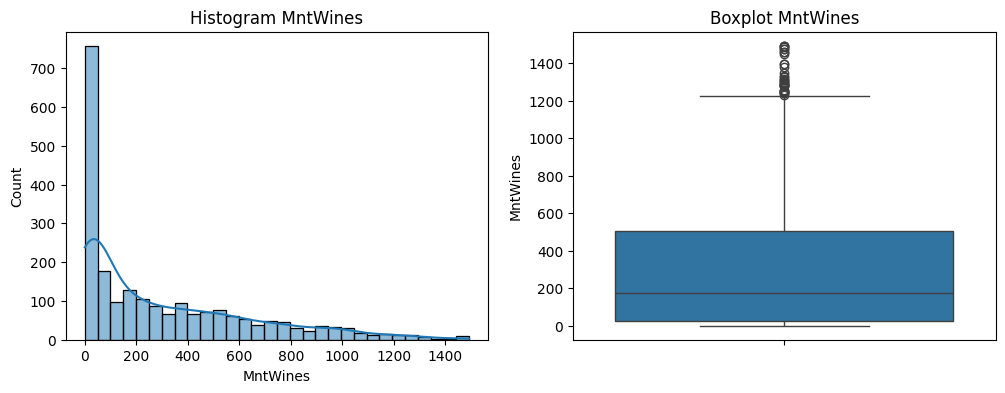

Skewness: 1.17
Kurtosis: 0.58


Graph MntFruits


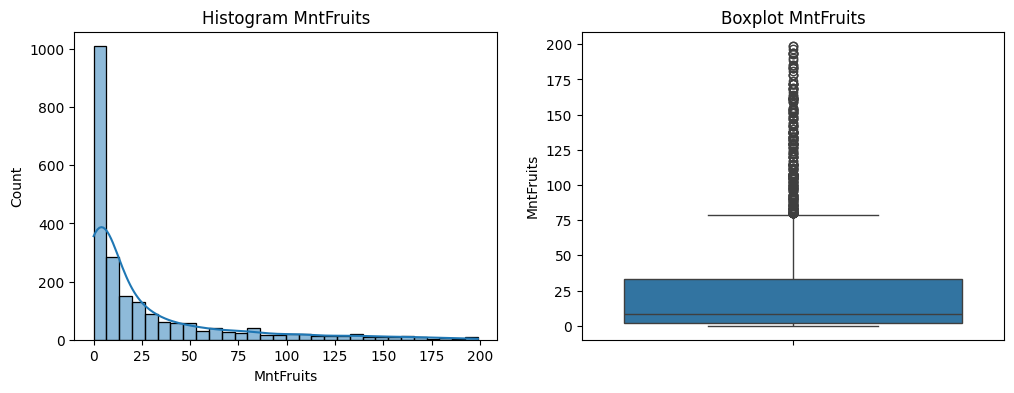

Skewness: 2.10
Kurtosis: 4.07


Graph MntMeatProducts


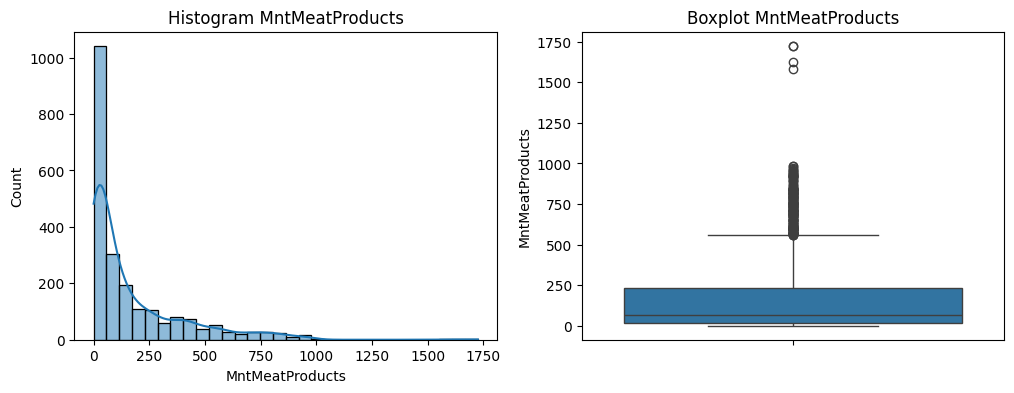

Skewness: 2.02
Kurtosis: 5.05


Graph MntFishProducts


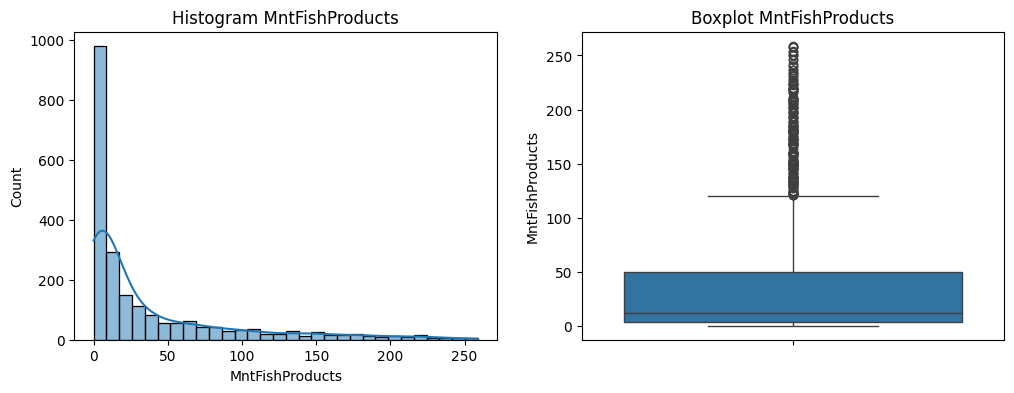

Skewness: 1.92
Kurtosis: 3.10


Graph MntSweetProducts


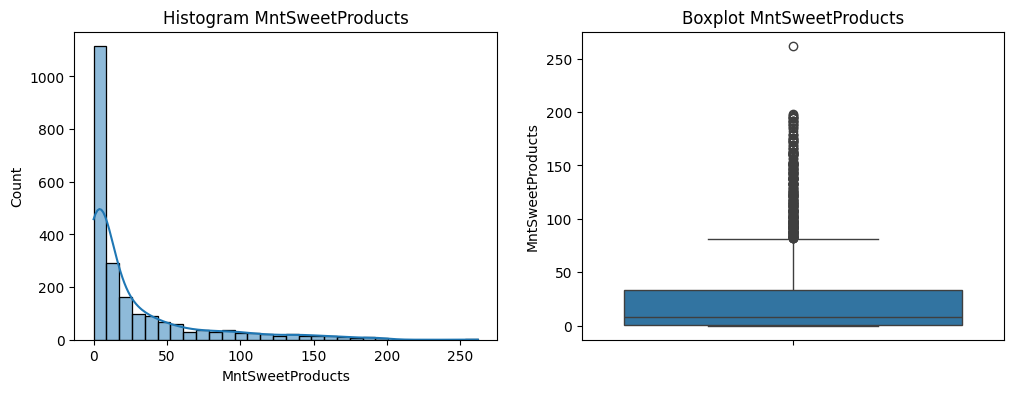

Skewness: 2.10
Kurtosis: 4.09


Graph MntGoldProds


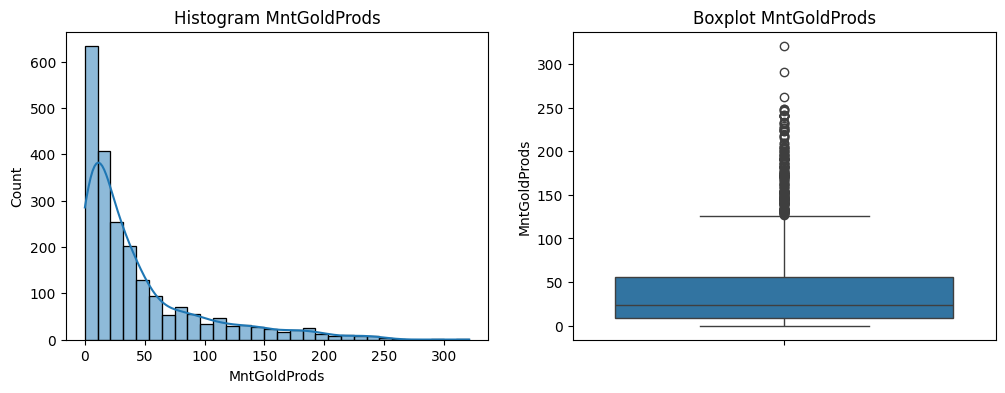

Skewness: 1.84
Kurtosis: 3.15


Graph NumDealsPurchases


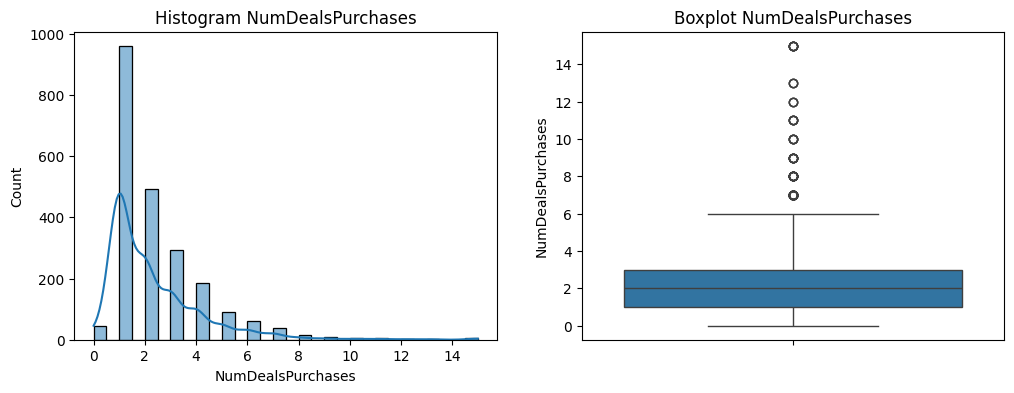

Skewness: 2.43
Kurtosis: 9.03


Graph NumWebPurchases


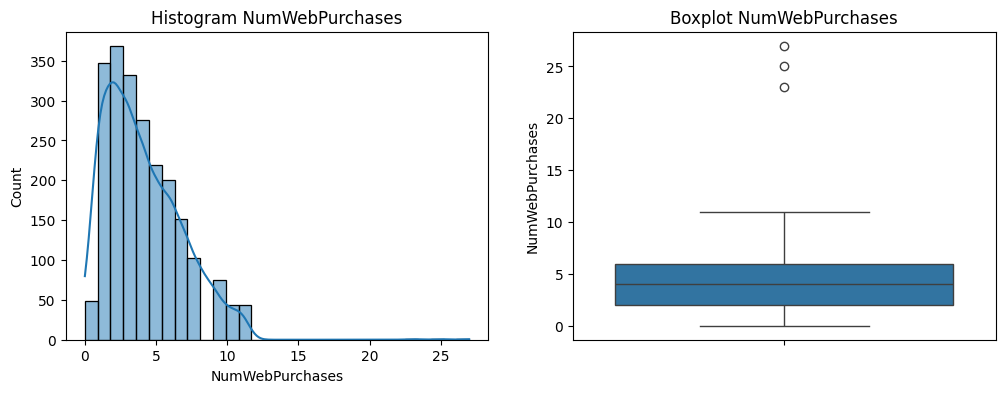

Skewness: 1.20
Kurtosis: 4.10


Graph NumCatalogPurchases


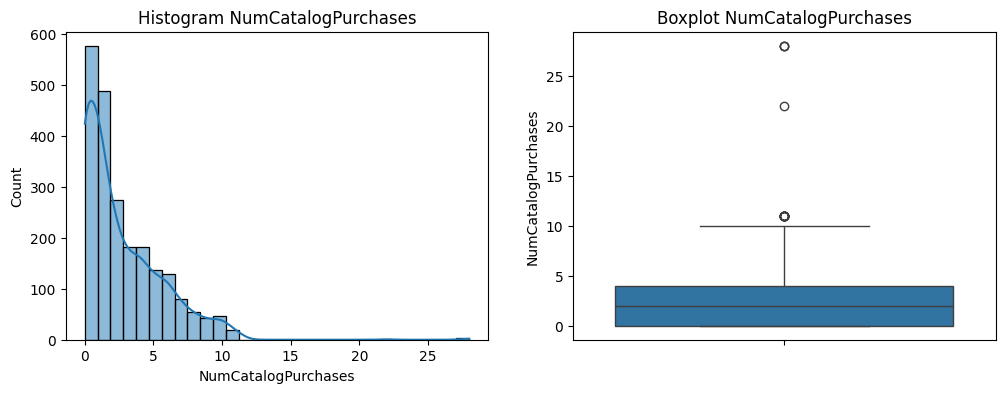

Skewness: 1.88
Kurtosis: 8.10


Graph NumStorePurchases


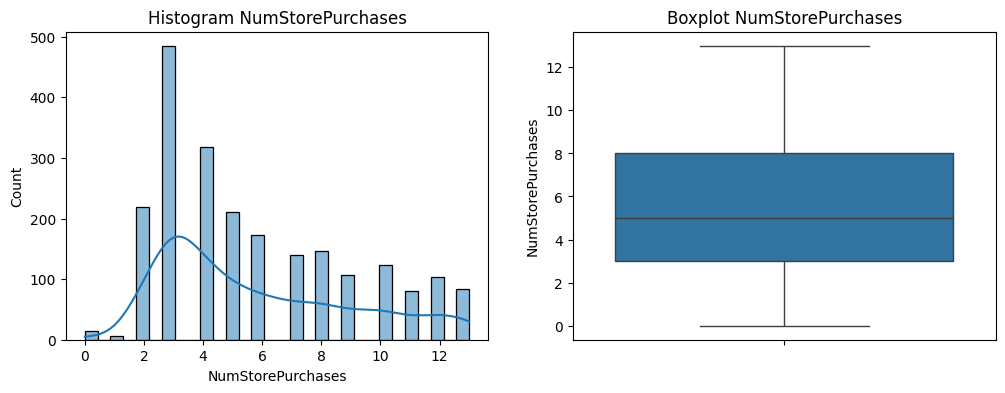

Skewness: 0.70
Kurtosis: -0.63


Graph NumWebVisitsMonth


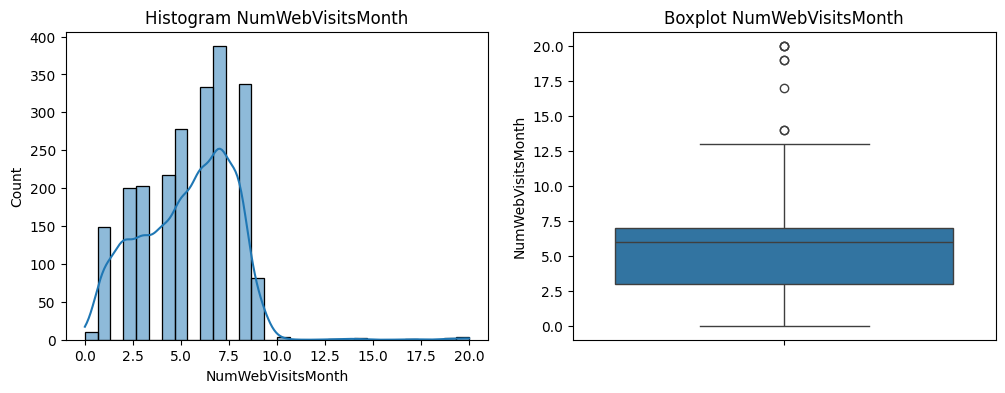

Skewness: 0.22
Kurtosis: 1.87


Graph Month_Cust


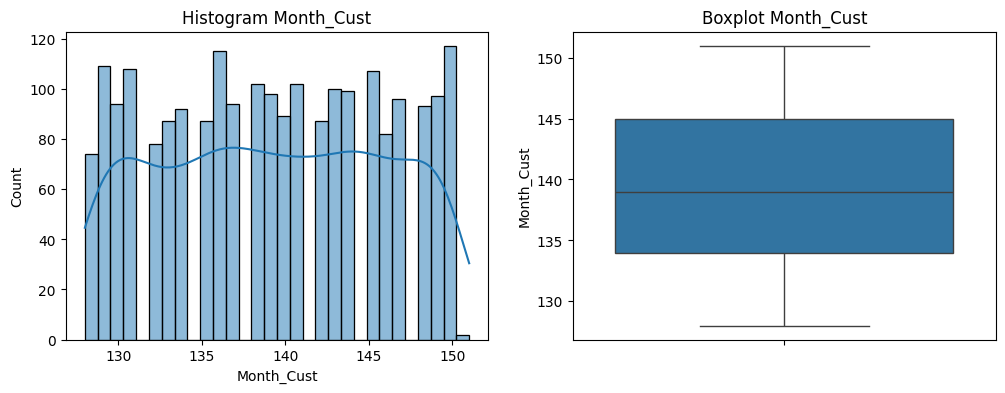

Skewness: -0.01
Kurtosis: -1.20


Graph Age


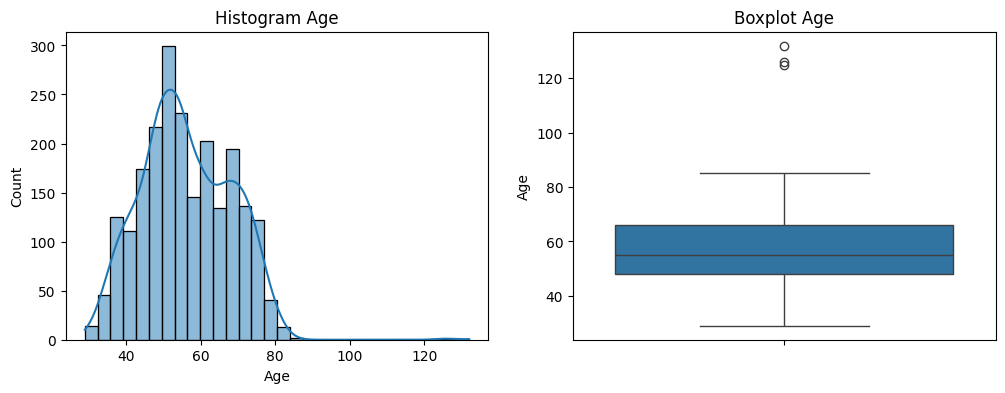

Skewness: 0.36
Kurtosis: 0.74




In [18]:
'''
Input: dataframe berisi data yang ingin diketahui distribusinya dan daftar nama column yg ingin dianalisis
Proses: menghasilkan histogram dan boxplot untuk tiap column, serta menghitung nilai kurtosis (keruncingan distribusi data) dan skewness (seberapa condong distirbusi data)
Output: print graph dan nilai kurtosis serta skewness
'''
def print_distribution(df, cols):
    for col in cols:
        print("Graph", col)

        # Figure untuk print plot dalam satu baris
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))

        # Histogram
        sns.histplot(df[col], bins=30, kde=True, ax=axes[0])
        axes[0].set_title(f'Histogram {col}')
        # Boxplot
        sns.boxplot(y=df[col], ax=axes[1])
        axes[1].set_title(f'Boxplot {col}')
        plt.show()

        # Nilai skewness dan kurtosis
        print(f'Skewness: {df[col].skew():.2f}')
        print(f'Kurtosis: {df[col].kurt():.2f}\n\n')

print_distribution(data_raw, numerical_cols)

Dari plot distribusi diatas bisa disimpulkan bahwa sebagian besar column numerik (Income, Kidhome, Teenhome, MntWines, MntFruits, MntMeatProducts, MntFishProducts, MntSweetProducts, MntGoldProds, NumDealsPurchases, NumWebPurchases, NumCatalogPurchases, NumStorePurchases, NumWebVisitsMonth, Age) memiliki ditribusi miring ke kanan. Sedangkan 2 column lainnya (Recency, Month_Cust) berdistribusi normal.

Pada beberapa column, spt Kidhome, Teenhome, Recency, NumStorePurchases, Month_Cust tidak ditemukan outlier, sedangkan sisanya ada.

Dari sini karena banyak fitur yang berdistribusi normal dan mayoritas memiliki outlier, jadi saya memilih untuk menggunakan scaler Robust Scaler krn scaler ini tahan terhadap outlier dan bagus utk data tidak berdistribusi normal


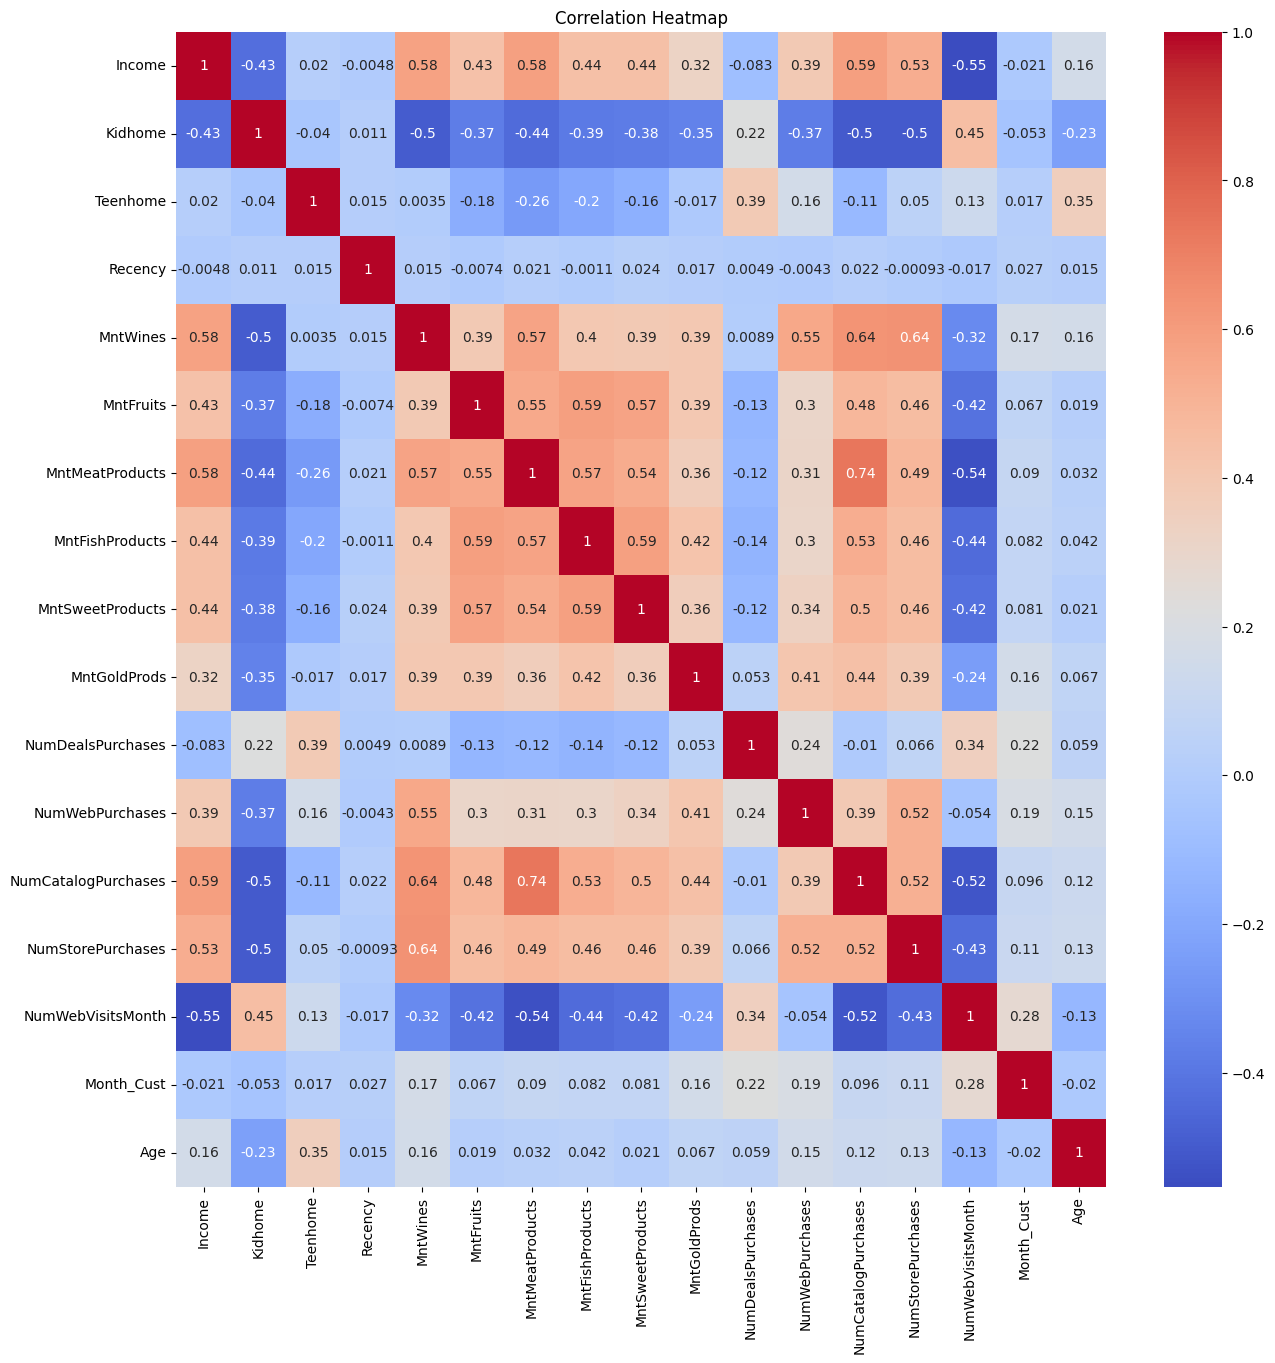

In [19]:
plt.figure(figsize=(15, 15))
correlation_data = data_raw[numerical_cols].corr() # Hitung korelasi antar variabel numerik
sns.heatmap(correlation_data, cmap='coolwarm', annot=True)
plt.title('Correlation Heatmap')
plt.show()

Dari correlation plot diatas, ada beberapa fitur yang punya korelasi tinggi yang bisa dijumlahkan, seperti:
1. Total pengeluaran seseorang -> Total_Spending = MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts + MntGoldProds
2. Total jumlah pembelian -> Total_Purchases = NumDealsPurchases + NumWebPurchases + NumCatalogPurchases + NumStorePurchases


In [20]:
# Membuat dataframe baru dengan mengcopy
df = data_raw.copy()

##### Feature Engineering

In [21]:
# Menambahkan 2 fitur baru (total pengeluaran dan total jumlah pembelian)
df['Total_Spending'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['Total_Purchases'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases']
# Menghapus column2 yang sudah dibentuk jdi column baru
# df.drop(columns=['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases'], inplace=True)
# Menambahkan column baru ke list numerical column baru dan menghapus column yang lama
numerical_cols2 = numerical_cols.copy() # membuat copy list yang lama
numerical_cols2.extend(['Total_Spending', 'Total_Purchases'])
# numerical_cols2 = [col for col in numerical_cols2 if col not in ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases']]
print('New Numerical columns:', numerical_cols2)

New Numerical columns: ['Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Month_Cust', 'Age', 'Total_Spending', 'Total_Purchases']


##### Encoding

In [22]:
# Untuk 2 kategorical variabel yang masi bertipe data object, akan digunakan 2 tipe encoding yang berbeda

# 1. Column Marital_Status
df = pd.get_dummies(df, columns=['Marital_Status'], drop_first=True)
# 2. Column Education
ord_enc = OrdinalEncoder(categories=[['Basic','Graduation','2n Cycle','Master','PhD']])
df['Education'] = ord_enc.fit_transform(df[['Education']])

df.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Complain,Response,Month_Cust,Age,Total_Spending,Total_Purchases,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,1.0,58138.0,0,0,58,635,88,546,172,88,...,0,1,149,68,1617,25,False,True,False,False
1,1.0,46344.0,1,1,38,11,1,6,2,1,...,0,0,131,71,27,6,False,True,False,False
2,1.0,71613.0,0,0,26,426,49,127,111,21,...,0,0,138,60,776,21,False,False,True,False
3,1.0,26646.0,1,0,26,11,4,20,10,3,...,0,0,132,41,53,8,False,False,True,False
4,4.0,58293.0,1,0,94,173,43,118,46,27,...,0,0,133,44,422,19,True,False,False,False


##### Scaling

In [23]:
# Karena banyak fitur numerikal yang skwed dan ada outlier jadi saya memutuskan untuk scaling menggunakan Robust Scaler yang rentan terhadap outlier dan digunakan pd data berdistribusi tidak normal
rob_scaler = RobustScaler()
df[numerical_cols2] = rob_scaler.fit_transform(df[numerical_cols2])
df.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,Complain,Response,Month_Cust,Age,Total_Spending,Total_Purchases,Marital_Status_Married,Marital_Status_Single,Marital_Status_Together,Marital_Status_Widow
0,1.0,0.202151,0.0,0.0,0.18,0.958420,2.580645,2.202765,3.404255,2.50000,...,0,1,0.909091,0.722222,1.247191,0.769231,False,True,False,False
1,1.0,-0.151164,1.0,1.0,-0.22,-0.338877,-0.225806,-0.285714,-0.212766,-0.21875,...,0,0,-0.727273,0.888889,-0.376915,-0.692308,False,True,False,False
2,1.0,0.605824,0.0,0.0,-0.46,0.523909,1.322581,0.271889,2.106383,0.40625,...,0,0,-0.090909,0.277778,0.388151,0.461538,False,False,True,False
3,1.0,-0.741260,1.0,0.0,-0.46,-0.338877,-0.129032,-0.221198,-0.042553,-0.15625,...,0,0,-0.636364,-0.777778,-0.350358,-0.538462,False,False,True,False
4,4.0,0.206794,1.0,0.0,0.90,-0.002079,1.129032,0.230415,0.723404,0.59375,...,0,0,-0.545455,-0.611111,0.026558,0.307692,True,False,False,False


### Dimesion Reduction

In [24]:
pca = PCA() # inisiasi pca
pca.fit(df) # fit ke data kita

PCA()

([<matplotlib.axis.YTick at 0x159b51abcd0>,
 [Text(0, 0, '0'),
  Text(0, 10, '10'),
  Text(0, 20, '20'),
  Text(0, 30, '30'),
  Text(0, 40, '40'),
  Text(0, 50, '50'),
  Text(0, 60, '60'),
  Text(0, 70, '70'),
  Text(0, 80, '80'),
  Text(0, 90, '90'),
  Text(0, 100, '100')])

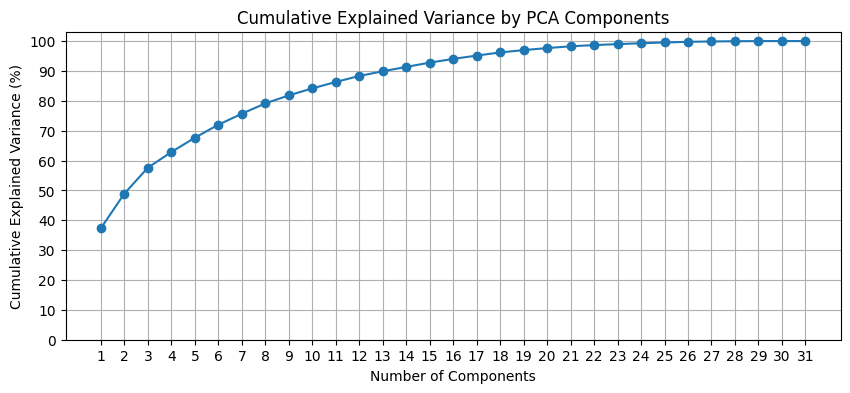

In [25]:
cumulative_var = np.cumsum(pca.explained_variance_ratio_ * 100)

plt.figure(figsize=(10, 4))
plt.grid()
plt.plot(range(1, len(cumulative_var) + 1), cumulative_var, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance (%)')
plt.title('Cumulative Explained Variance by PCA Components')
plt.xticks(range(1, len(cumulative_var) + 1))
plt.yticks(np.arange(0, 110, 10))

Pada plot varians kumulatif, kita mencari titik elbow dimana perubahan kenaikan varians mulai mengecil. Dari graph tersebut bisa dilihat bahwa pada titik 3, kenaikan varians mulai mengecil yang artinya 3 komponen pertama menangkap sebagian besar informasi

([<matplotlib.axis.YTick at 0x159b43de6e0>,
 [Text(0, 0.0, '0'),
  Text(0, 1.0, '1'),
  Text(0, 2.0, '2'),
  Text(0, 3.0, '3'),
  Text(0, 4.0, '4'),
  Text(0, 5.0, '5'),
  Text(0, 6.0, '6')])

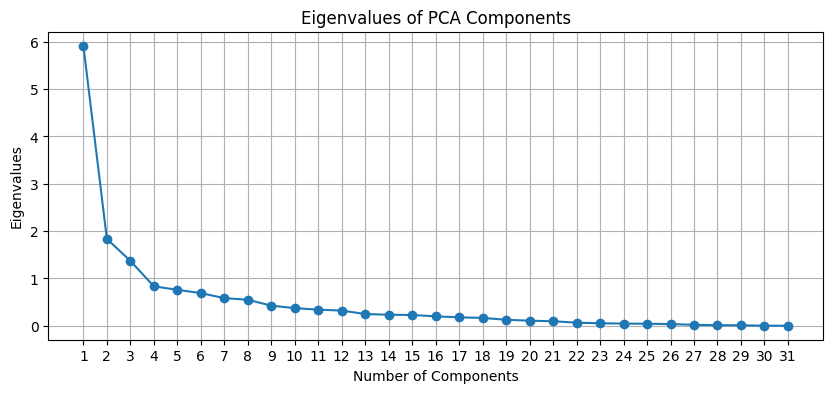

In [26]:
eigenvalues = pca.explained_variance_

# Plot utk eigen value
plt.figure(figsize=(10, 4))
plt.grid()
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalues')
plt.title('Eigenvalues of PCA Components')
plt.xticks(range(1, len(eigenvalues) + 1))
plt.yticks(np.arange(0, max(eigenvalues) + 1, 1))  # Set y-axis increments

Pada plot eigenvalue, kita mencari titik elbow dimana penurunan eigenvalue mulai melambat. Dari grafik ini, dapat dilihat jika pada titik ke3, penurunan eigenvalue mulai melambat yang artinya komponen setelahnya tidak menambah banyak informasi

In [27]:
# Dari ke2 plot diatas, jumlah komponen yang ideal adalah 3 shg saya reduce dataset jadi hanya 3 komponen
pca3_komp = PCA(n_components=3) # membuat pca utk 3 komponen
df_pca3 = pca3_komp.fit_transform(df) # menerapkan pca pada dataframe skrg

### Modelling

Jumlah clusters 2:
  Silhouette_score: 0.4631156622315193
  WCSS: 10001.040893133366
Jumlah clusters 3:
  Silhouette_score: 0.38102785739683076
  WCSS: 7683.118345406027
Jumlah clusters 4:
  Silhouette_score: 0.3831156900181853
  WCSS: 5962.5727665303475
Jumlah clusters 5:
  Silhouette_score: 0.39771920600267185
  WCSS: 4834.938482269795
Jumlah clusters 6:
  Silhouette_score: 0.3792891558035257
  WCSS: 4152.857286685432
Jumlah clusters 7:
  Silhouette_score: 0.4030004679778246
  WCSS: 3436.2571124615833
Jumlah clusters 8:
  Silhouette_score: 0.39416727427953346
  WCSS: 3172.571822709696
Jumlah clusters 9:
  Silhouette_score: 0.3935570683630637
  WCSS: 2924.527261665713


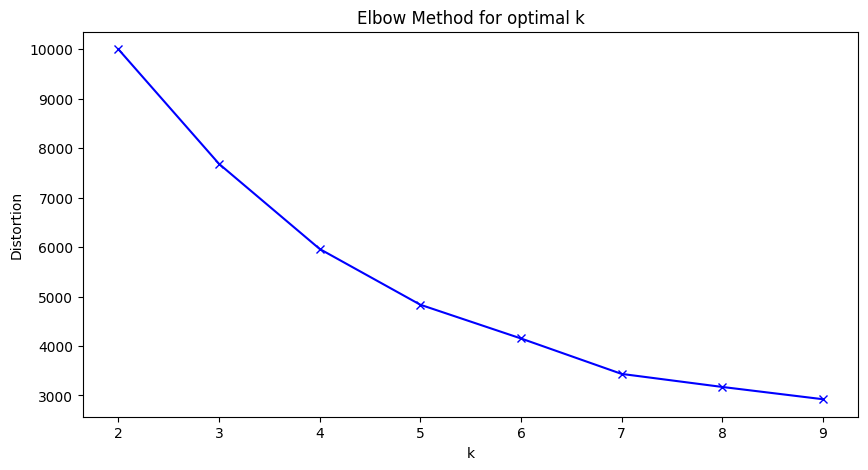

In [28]:
# List untuk menyimpan WCSS dan silhouette score tiap k
distortions = []
silhouettes = []

K = range(2, 10) # Mencoba semua kluster dari 2 cluster hingga 9

# Iterasi jumlah cluster
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=SEEEEEDDDD) # Model kmeans dengan k cluster
    cluster_label = kmeanModel.fit_predict(df_pca3) # Train model skaligus predict

    # Hitung nilai silhouette score
    silhouette_avg = silhouette_score(df_pca3, cluster_label)

    # Print silhouette score dan WCSS/ inertia
    print(f"Jumlah clusters {k}:")
    print(f"  Silhouette_score: {silhouette_avg}")
    print(f"  WCSS: {kmeanModel.inertia_}")

    # Memasukan WCSS dan silhouette score ke list masing2
    distortions.append(kmeanModel.inertia_)
    silhouettes.append(silhouette_avg)

plt.figure(figsize=(10,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Elbow Method for optimal k')
plt.show()

Untuk elbow method mencari jumlah k optimal, diliat pada titik dimana WCSS (Within-Cluster Sum of Squares) mulai menurun lambat/ landai. Jadi, saya memutuskan utk mengambil 3 cluster

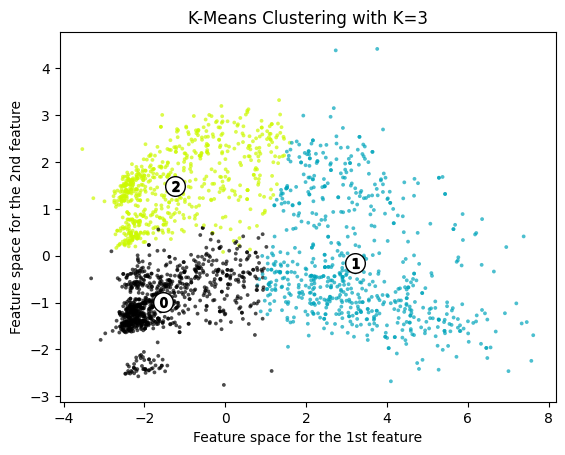

In [29]:
# Saya pilih jumlah cluster 3 sbg yg plg optimal
k = 3

# Inisiasi model dengan jumlah cluster 3
kmeans = KMeans(n_clusters = 3, random_state = SEEEEEDDDD)
pred = kmeans.fit_predict(df_pca3) # train model sekaligus predict

pca_comp = PCA(n_components=2) # pca dgn 2 dimensi utk visualisasi
df_pca2 = pca_comp.fit_transform(df)

colors = cm.nipy_spectral(pred.astype(float) / k) # warna utk tiap cluster

# Scatter plot dan diberi warna berdsrkan cluster
plt.scatter(df_pca2[:, 0], df_pca2[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

centers = kmeans.cluster_centers_ # titik tengah cluster
# Menandai titik tengah cluster dengan lingakran putih
plt.scatter( centers[:, 0], centers[:, 1], marker="o", c="white", alpha=1, s=200, edgecolor="k", )

# Beri label pada titik tengah cluster
for i, c in enumerate(centers):
    plt.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

plt.title("K-Means Clustering with K=3")
plt.xlabel("Feature space for the 1st feature")
plt.ylabel("Feature space for the 2nd feature")
plt.show()

In [30]:
df_kmeans = data_raw.copy()
df_kmeans['Cluster'] = pred # menambah column baru di dataset awal

In [31]:
df_kmeans.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Month_Cust,Age,Cluster
0,Graduation,Single,58138.0,0,0,58,635,88,546,172,...,0,0,0,0,0,0,1,149,68,1
1,Graduation,Single,46344.0,1,1,38,11,1,6,2,...,0,0,0,0,0,0,0,131,71,0
2,Graduation,Together,71613.0,0,0,26,426,49,127,111,...,0,0,0,0,0,0,0,138,60,1
3,Graduation,Together,26646.0,1,0,26,11,4,20,10,...,0,0,0,0,0,0,0,132,41,0
4,PhD,Married,58293.0,1,0,94,173,43,118,46,...,0,0,0,0,0,0,0,133,44,2


### Hasil Clustering

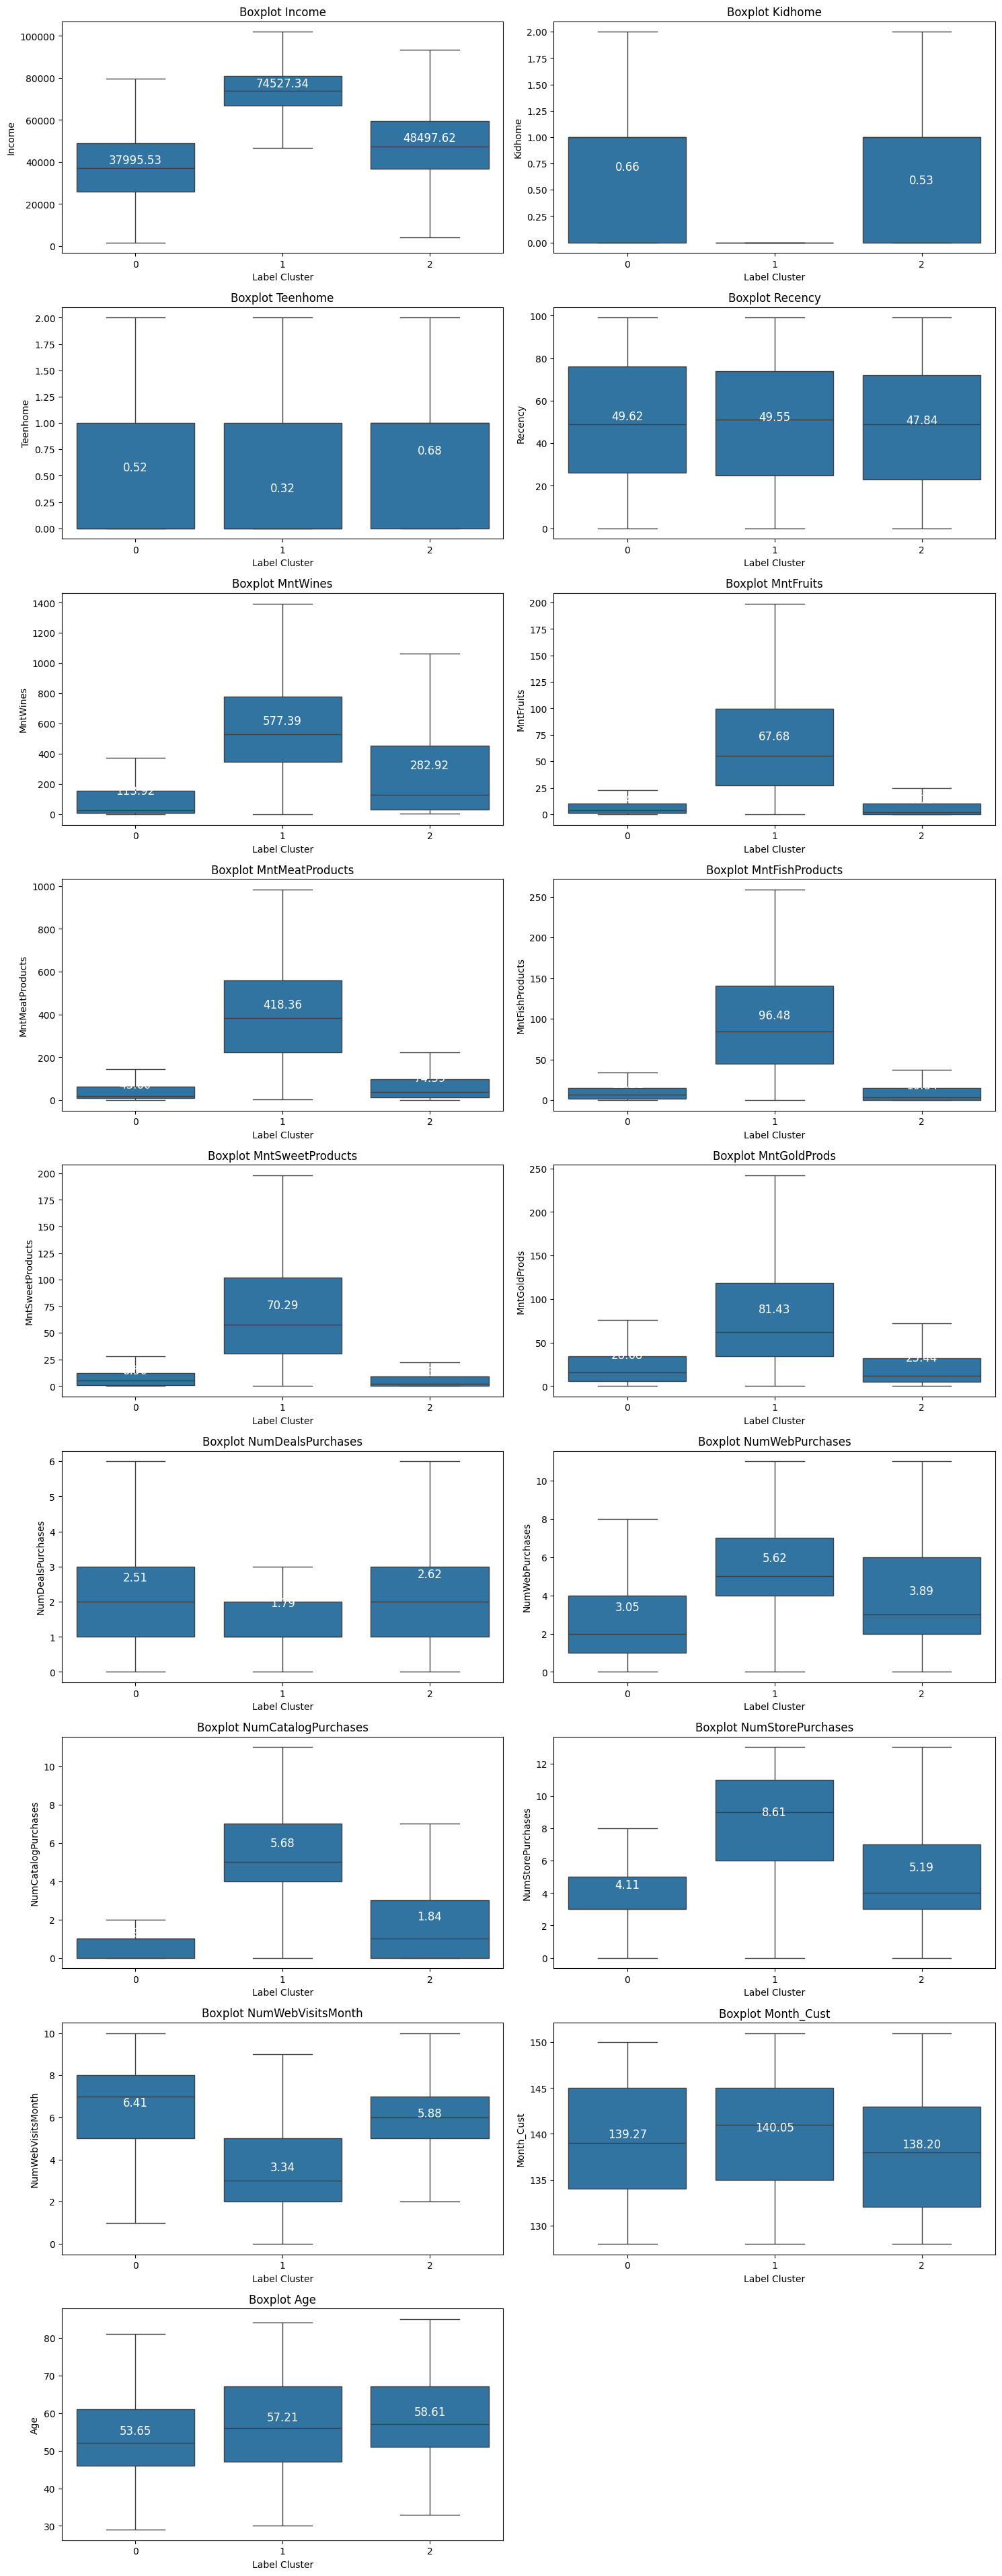

In [32]:
plt.figure(figsize=(15, 72))

# Iterasi tiap fitur di column numeric kemudian print masing2 boxplot
for i, fitur in enumerate(numerical_cols, 1):
    # Buat subplot
    plt.subplot(len(numerical_cols), 2, i)
        # Buat boxplot untuk tiap column yang digroup berdasarkan 'Cluster' (tanpa tunjukkan outlier)
    sns.boxplot(x='Cluster', y=fitur, data=df_kmeans, showfliers=False)

    plt.xlabel('Label Cluster', fontsize=10)
    plt.ylabel(fitur, fontsize=10)
    plt.title(f'Boxplot {fitur}', fontsize=12)

    # Menambahkan mean untuk tiap cluster di boxplot
    means = df_kmeans.groupby('Cluster')[fitur].mean().values
    for j, mean in enumerate(means):
        # Menampilkan mean di boxplot
        plt.text(j, mean, f'{mean:.2f}', ha='center', va='bottom', color='white', fontsize=12)

plt.tight_layout()
plt.show()

1. Pendapatan: Cluster 1 punya pendapatan tertinggi, diikuti oleh Cluster 2, sedangkan Cluster 0 punya pendapatan paling rendah
2. Kidhome: Cluster 1 cenderung tidak punya anak kecil, sedangkan Cluster 0 dan Cluster 2 punya lebih banyak anak kecil
3. Teenhome: Semua cluster diperkirakan memiliki 1 anak remaja di rumah
4. Recency: Tidak ada perbedaan signifikan antar cluster dalam jumlah hari sejak pembelian terakhir
5. MntWines: Cluster 1 paling banyak membeli wine, diikuti oleh Cluster 2, sedangkan Cluster 0 paling sedikit membeli wine
6. MntFruits: Cluster 1 paling banyak membeli buah, sementara Cluster 0 dan Cluster 2 punya pengeluaran yang jauh lebih kecil
7. MntMeatProducts: Cluster 1 paling banyak membeli daging, diikuti oleh Cluster 2, dan Cluster 0 paling sedikit membeli daging
8. MntFishProducts: Cluster 1 paling banyak membeli produk ikan, sementara Cluster 0 dan Cluster 2 punya pengeluaran yang rendah
9. MntSweetProducts: Cluster 1 lebih sering membeli makanan manis, sedangkan Cluster 0 dan Cluster 2 jarang membeli produk manis
10. MntGoldProds: Cluster 1 paling banyak membeli produk emas, sedangkan Cluster 0 dan Cluster 2 jarang membeli emas
11. NumDealsPurchases: Cluster 0 dan Cluster 2 lebih sering membeli dengan diskon, sedangkan Cluster 1 lebih jarang memanfaatkan diskon
12. NumWebPurchases: Cluster 1 lebih sering belanja online, sedangkan Cluster 0 dan Cluster 2 lebih sedikit belanja online
13. NumCatalogPurchases: Cluster 1 lebih sering membeli melalui katalog, sedangkan Cluster 2 punya jumlah pembelian katalog paling sedikit
14. NumStorePurchases: Cluster 1 paling sering berbelanja di offline store, sedangkan Cluster 2 lebih jarang berbelanja di toko
15. NumWebVisitsMonth: Cluster 0 lebih sering mengunjungi website, sementara Cluster 1 punya jumlah kunjungan website paling sedikit
16. Month_Cust: Tidak ada perbedaan signifikan dalam lama berlangganan antar cluster
17. Age: Cluster 2 punya usia tertinggi, diikuti oleh Cluster 1, sementara Cluster 0 punya usia lebih muda meskipun bedanya tidak terlalu signifikan

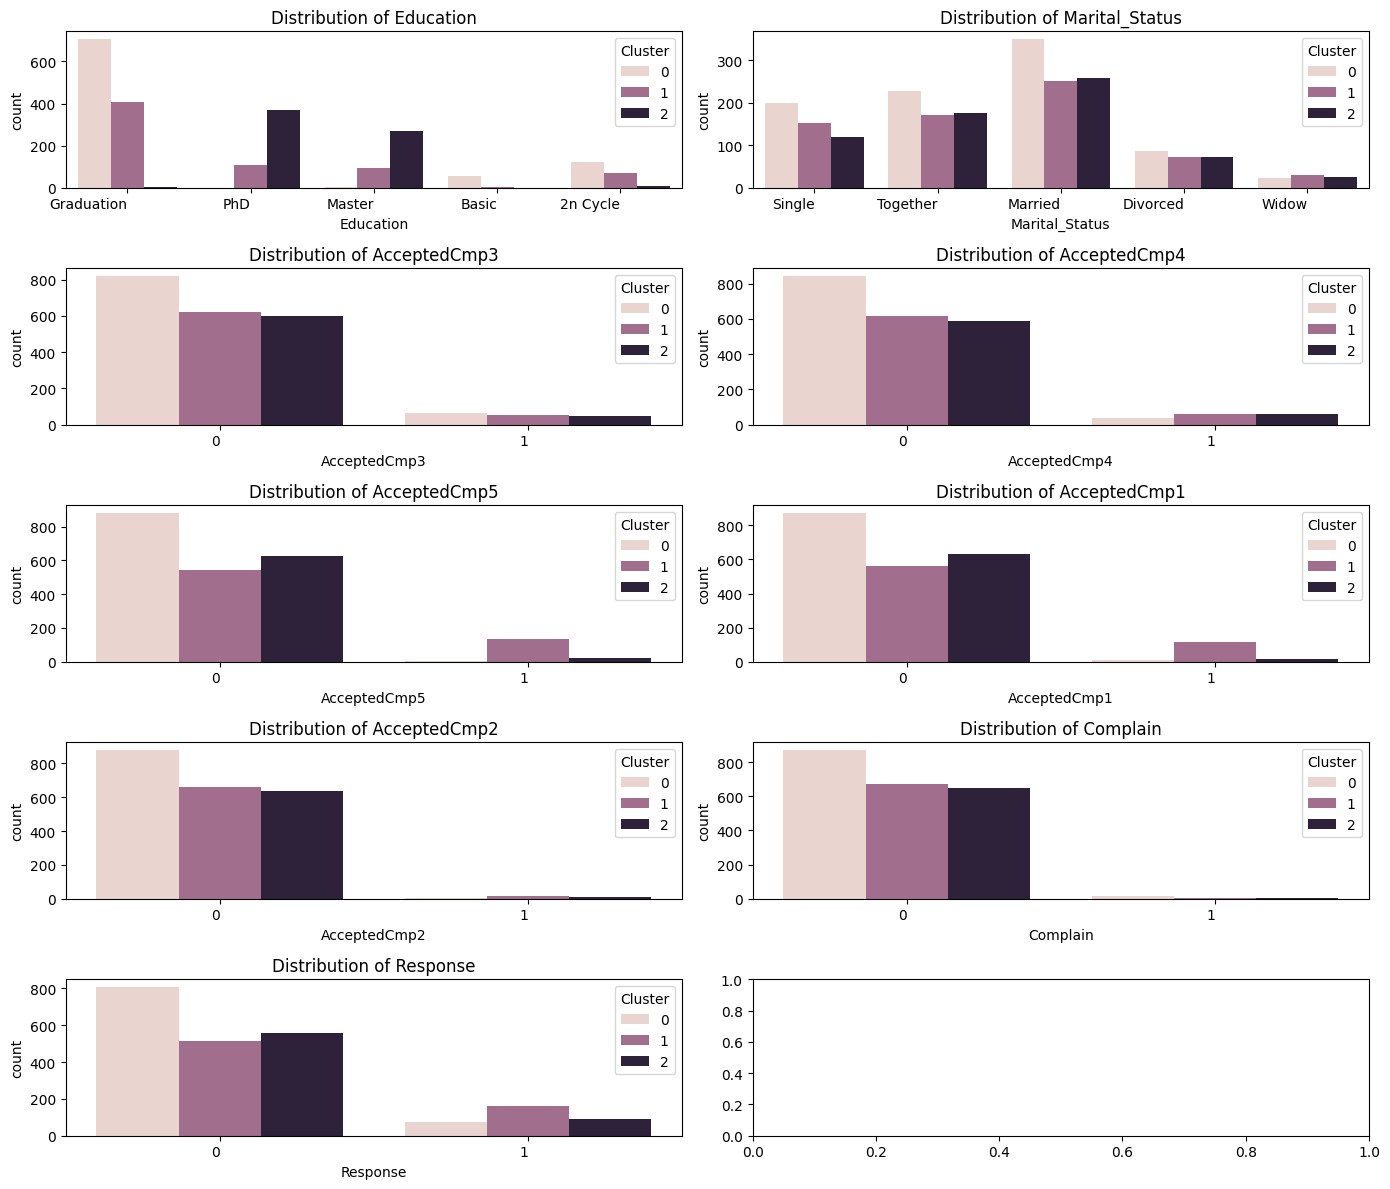

In [33]:
num_cols = len(categorical_cols)
num_rows = (num_cols + 1) // 2  # jumlah baris yg dibutuhkan

fig, axes = plt.subplots(num_rows, 2, figsize=(14, 12))

# Iterasi tiap kolom categorikal dan membuat plot distribusi berdasarkan cluster
for i, col in enumerate(categorical_cols):
    ax = axes[i // 2, i % 2] if num_cols > 1 else axes[0, i]  # posisi subplot berdsrkan jumlah column
    sns.countplot(data=df_kmeans, x=col, hue='Cluster', ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xticklabels(ax.get_xticklabels(), ha="right")

plt.tight_layout()
plt.show()

1. Education: Cluster 0 didominasi oleh orang berpendidikan Graduation (S1) hampir sama dengan Cluster 1, sedangkan Cluster 2 lebih banyak berpendidikan PhD (S3) dan Master (S2)  
2. Marital_Status: Semua cluster didominasi oleh orang yang sudah menikah  
3. AcceptedCmp1 sampai AcceptedCmp5: Semua cluster memiliki kesamaan yaitu mayoritas tidak menerima campaign marketing, baik dari campaign ke1 hingga ke5
4. Complain: Semua cluster mayoritasnya jarang mengajukan complain
5. Response: Semua cluster didominasi oleh orang yang tidak merespons campaign, tetapi di antara mereka yang merespons, Cluster 1 memiliki jumlah terbanyak

In [34]:
df_kmeans.groupby('Cluster').agg(
    {
        # Hitung mean untuk kolom numerical
        **{col: 'mean' for col in numerical_cols},
        # Hitung modus untuk kolom categorikal
        **{col: lambda x: x.mode()[0] for col in categorical_cols}
    }
).reset_index().T

,0,1,2
Cluster,0,1,2
Income,37995.526554,74527.337778,48497.616333
Kidhome,0.657627,0.071111,0.533128
Teenhome,0.517514,0.32,0.681048
Recency,49.621469,49.545185,47.844376
MntWines,113.919774,577.394074,282.918336
MntFruits,8.494915,67.678519,7.730354
MntMeatProducts,43.60339,418.357037,74.389831
MntFishProducts,12.20904,96.475556,10.842835
MntSweetProducts,8.555932,70.293333,7.377504


Dari hasil tabel diatas, berikut kesimpulan karakteristik msing-masing cluster:

Cluster 0 terdiri dari pelanggan dengan pendapatan rendah yang cenderung memiliki lebih banyak anak kecil di rumah. Mereka lebih sering memanfaatkan diskon dan punya pengeluaran yang rendah di hampir semua kategori produk. Mereka jarang membeli barang dalam jumlah besar, terutama untuk produk seperti wine, daging, dan emas. Mereka lebih aktif mengunjungi website perusahaan, kemungkinan untuk mencari diskon/ promo sebelum membeli. Namun, mereka jarang belanja online maupun melalui katalog dan lebih mengandalkan pembelian di offline store. Selain itu, mayoritas pelanggan dalam cluster ini memiliki pendidikan tingkat Graduation (S1) dan sudah menikah. Mereka cenderung tidak merespons campaign marketing.  

Cluster 1 adalah kelompok pelanggan kls atas dengan daya beli tertinggi yang lebih jarang memiliki anak kecil atau remaja di rumah. Mereka punya pengeluaran yang jauh lebih besar dibandingkan cluster lainnya, terutama untuk produk seperti wine, daging, ikan, dan emas, menunjukkan preferensi terhadap produk premium dan berkualitas tinggi. Mereka lebih aktif dalam belanja online serta katalog, yang menunjukkan kecenderungan mereka melakukan pembelian terencana dan tidak hanya bergantung pada diskon. Meskipun mereka jarang mengunjungi website perusahaan dibandingkan cluster lainnya, mereka tetap menjadi pelanggan dengan kontribusi terbesar dalam total pembelian. Mayoritas pelanggan dalam cluster ini memiliki pendidikan tinggi (Graduation/S1) dan sudah menikah. Mereka juga menunjukkan ketidakresponsifan terhadap campaign marketing.  

Cluster 2 terdiri dari pelanggan dengan usia lebih tua dan daya beli menengah. Mereka memiliki lebih banyak anak remaja di rumah dibandingkan dua cluster lainnya dan cenderung memiliki pola belanja yang lebih seimbang. Pengeluaran mereka lebih tinggi daripada Cluster 0 tetapi masih jauh lebih rendah dari Cluster 1, terutama dalam kategori produk makanan dan minuman. Mereka lebih sering memanfaatkan diskon dalam pembelian mereka, menunjukkan bahwa meskipun mereka memiliki daya beli yang lebih baik dari Cluster 0, mereka tetap mempertimbangkan harga dalam keputusan beli. Mereka cukup aktif dalam belanja online, lebih sering mengunjungi website dibandingkan Cluster 1, dan memiliki frekuensi belanja yang lebih stabil melalui katalog dan offline store. Dengan mayoritas pelanggan berpendidikan PhD dan sudah menikah, Cluster 2 juga tidak responsifterhadap campaign marketing.

### Kesimpulan

Cluster 1 lebih eksklusif dengan daya beli tinggi dan suka produk premium, Cluster 0 lebih suka mencari diskon, sedangkan Cluster 2 berada di tengah dengn tipe belanja yang lebih fleksibel. Namun, kesamaan utama di antara ketiganya adalah mereka tidak responsitf pada campaign marketing, yang menunjukkan bahwa strategi promosi yang digunakan mungkin perlu disesuaikan untuk lebih mampu menarik perhatian pelanggan dari masing-masing cluster